### 인공 신경망 Artificial Neural Network (ANN)
인공 신경망은 사람의 신경망을 모사하여 만든 예측 도구이다.

기본적으로 하나의 레이어에 다수의 노드를 가지고 있으며 여러 개의 레이어가 쌓인 신경망을 깊은 신경망이라고 한다. 이 때, 깊은 신경망을 이용하여 모델을 학습 하는 방법을 딥러닝이라고 한다.

In [36]:
import pandas as pd # 엑셀처럼 표 형식의 데이터를 다룰 수 있게 해주는 라이브러리
import numpy as np # 배열, 행렬 계산을 도와주는 라이브러리
from sklearn.model_selection import train_test_split # 전체 데이터를 train(훈련용) 데이터와 test(테스트용) 데이터로 나눌 수 있게 도와줘 모델이 얼마나 잘 작동하는지 평가 할 수 있게 해준다.

# ANN

# torch: 딥러닝을 만들고 훈련할 수 있는 프레임워크 -> 텐서 연산, GPU 사용 등을 지원한다.
# nn: 신경망의 레이어나 구조를 만들때 사용
# optim: 모델을 학습시킬 때 파라미터를 최적화하는데 사용되는 도구 (예, SGD, Adam 등)
# Dataset: 데이터를 PyTorch 형식으로 정의하는 틀
# DataLoader: Dataset을 읽어와서 배치 단위로 나누고 shuffle하는 등 학습에 맞게 처리해 준다.

# torch.nn.functional
# torch 내의 세부적인 기능을 불러온다.
# 자주 쓰이는 활설화 함수(ReLU, softmax 등), 손실 함수, 기타 여러 기능을 포함하고 있다.
# 간단한 함수는 nn(neural network)보다 여기서 가져오는 게 더 가볍고 빠를 때가 많다.
import torch
from torch import nn, optim 
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Plot -> 시각화 코드가 나올 것을 의미한다.
import matplotlib.pyplot as plt # 시각화 도구, 학습 과정의 손실(loss) 그래프, 정확도 변화 등을 볼 수 있게 해준다.

#### 1. 데이터 불러오기
> feature : 피쳐는 머신러닝에서 데이터의 입력값(특징값)을 말한다.

In [37]:
df = pd.read_csv('./data/reg.csv', index_col=[0]) 
# index_col=[0]: index가 피쳐로 들어오는 것을 방지하고 데이터의 고유 번호(행 번호)로 쓰이도록 한다.

In [38]:
# 데이터프레임 보여주기
# 10줄을 보여준다.
df.head(10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


#### 2. 데이터 변수와 타겟값 나누기

In [52]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # df에서 'Price'라는 열(column)을 제거한 후, 나머지 열들만 넘파이 배열로 변환하여 X에 저장
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기, 1열로 되고 행은 -1로 인해 자동으로 계산된다.

print(X)
print(Y)

[[0.03463293 0.20691874 0.13705684 ... 0.34760885 0.99639409 0.10264398]
 [0.02892023 0.01431456 0.27611271 ... 0.52077557 0.99665033 0.18711954]
 [0.02062738 0.03322998 0.28111574 ... 0.59530071 0.98328389 0.0840788 ]
 ...
 [0.03535199 0.02149474 0.42391812 ... 0.78270371 0.99579054 0.09404364]
 [0.02618206 0.02860316 0.44344242 ... 0.74918576 0.9868548  0.10739872]
 [0.04551912 0.02928918 0.44615622 ... 0.83523695 0.99422078 0.14630181]]
[[0.42222222]
 [0.36888889]
 [0.66      ]
 [0.63111111]
 [0.69333333]
 [0.52666667]
 [0.39777778]
 [0.49111111]
 [0.25555556]
 [0.30888889]
 [0.22222222]
 [0.30888889]
 [0.37111111]
 [0.34222222]
 [0.29333333]
 [0.33111111]
 [0.40222222]
 [0.27777778]
 [0.33777778]
 [0.29333333]
 [0.19111111]
 [0.32444444]
 [0.22666667]
 [0.21111111]
 [0.23555556]
 [0.19777778]
 [0.25777778]
 [0.21777778]
 [0.29777778]
 [0.35555556]
 [0.17111111]
 [0.21111111]
 [0.18222222]
 [0.18      ]
 [0.18888889]
 [0.30888889]
 [0.33333333]
 [0.35555556]
 [0.43777778]
 [0.573333

#### 3. 텐서 데이터와 배치 만들기

In [40]:
# 모델 학습에 필요한 데이터를 텐서 데이터로 변환하는 클래스 (data_loader 파일 참고)
# 입력값(x)과 목표값(y)의 단위 형태를 맞춰야 추후 과정에 용이하다.(예측 결과와 정답의 비교 시, loss 계산 시 등등)
class TensorData(Dataset):
  def __init__(self, x_data, y_data):
    self.x_data = torch.FloatTensor(x_data) # float 타입의 텐서로 바꿔준다.
    self.y_data = torch.FloatTensor(y_data)
    self.len = self.y_data.shape[0] # [행, 열] 중 행에 해당한다.

  # (입력, 타겟) 튜플 형태로 데이터를 반환
  # PyTorch는 이 메서드를 통해 DataLoader에서 한 샘플씩 가져오게 된다.
  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]
  
  # 데이터셋의 전체 길이(샘플 수)를 리턴한다.
  def __len__(self):
    return self.len

In [ ]:
# train_test_split : 데이터를 랜덤하게 섞고(shuffle), 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# test size = 0.5 -> 전체 데이터 중 50%를 test용 데이터로, 나머지 50%는 학습용 데이터로 나누겠다는 의미다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# TensorData: PyTorch에서 사용할 수 있는 Dataset 형태로 변환
# DataLoader(묶음): Dataset을 batch 단위로 꺼낼 수 있게 만들어줌
# 학습 데이터 배치 형태로 구축하기
train_sets = TensorData(X_train, Y_train)
train_loader = DataLoader(train_sets, batch_size=32, shuffle=True)

# 시험 데이터 배치 형태로 구축하기
test_sets = TensorData(X_test, Y_test)
test_loader = DataLoader(test_sets, batch_size=32, shuffle=False)

# 만약 batch_size가 2 라면 아래처럼 두 샘플이 한 batch에 묶여서 들어오게 된다.
# 입력 x_batch: tensor([[ 3., 30.],
#                      [ 1., 10.]])
# 정답 y_batch: tensor([[300.],
#                      [100.]])

#### 4. 모델 구축

Regressor 모델(회귀 모델)는 입력층(노드 13개), 2개의 은닉층(50개, 30개), 출력층(1개)으로 구성한다.
* Regression = 회귀. 즉, 숫자를 예측하는 모델을 뜻한다. 숫자 범위 안에 정확히 얼마나 가까운지 맞추는 게 핵심이다. ex. 집값, 주식  

데이터의 변수는 13개이므로 입력층의 노드는 13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 

은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [42]:
# nn.Module을 상속받아서 Pytorch 모델 구조를 따름
class Regressor(nn.Module):
  def __init__(self):
    super().__init__() # nn.Module의 초기화 함수를 호출 -> PyTorch 내부에서 모델 파라미터를 추적하고 업데이트하려면 꼭 필요하다.
    self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
    self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
    self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
    self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

  # 실제 연산 순서 정의
  # 모델에 입력 x가 들어왔을 때 계산이 어떻게 흘러갈지를 정의
  # ❗️ 참고로 Regressor(x)와 같이 모델 인스턴스를 함수처럼 쓰면, forward()는 자동으로 호출되며 실행된다.
  def forward(self, x):
    x = F.relu(self.fc1(x)) # self.fc1(x) : 입력을 첫 번째 Linear 계층(13 -> 50)에 통과시키고, F.relu() -> 활성화 함수 ReLU를 적용한다. (음수는 0, 양수는 그대로)   
    x = self.dropout(F.relu(self.fc2(x))) # 두 번째 Linear 계층(50 -> 30)에 통과시키고, 은닉층2에서 드랍아웃을 적용한다. (즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
    x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다. (가격 예측) 
        
    return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

##### 회귀(Regression) vs 분류(Classification)

| 항목             | 회귀 (Regression)                     | 분류 (Classification)                  |
|------------------|----------------------------------------|-----------------------------------------|
| 예측 값           | 연속적인 숫자                          | 고정된 클래스(label) 중 하나           |
| 예시             | 집값 예측: `250000`, `301000`         | 이메일 분류: `스팸`, `일반`             |
| 출력 형태         | 하나의 실수 값 (예: `nn.Linear(..., 1)`) | 클래스 수만큼 출력 (예: `nn.Linear(..., 3)`) |
| 대표 모델 이름     | `Regressor`                            | `Classifier`                            |
| 손실 함수 (Loss) | `nn.MSELoss()`, `nn.L1Loss()`          | `nn.CrossEntropyLoss()` 등              |
| 평가 지표         | MSE, MAE, RMSE, R² 등                  | 정확도(Accuracy), 정밀도(Precision), 재현율 등 |
| 시각적 요약       | 🏠 입력: 면적, 방 수 → 출력: `356000`     | 📧 입력: 이메일 내용 → 출력: `스팸 or 일반`  |

#### 5. 모델, 손실함수, 최적화 방법 선언

In [43]:
model = Regressor()

# 손실함수
# MSE(평균 제곱 오차) = mean((예측값 - 실제값)^2)
criterion = nn.MSELoss()

# 모델을 학습시킬 때 파라미터를 어떻게 업데이트할지 결정하는 부분
# lr: 학습률이다. 한 번의 학습(step)에서 얼마나 크게 가중치를 조정할지를 의미한다. 크면 빨리 학습되지만 불안정할 수 있고, 작으면 안정적이지만 느릴 수 있다.
# weight_decay
# - L2 정규화의 정도, penalty 값을 의미한다. 1e-2:0.01, 1e-3:0.001,.., 1e-6
# - 값이 클수록 큰 가중치에 더 많은 패널티를 준다. 가중치 = 학습되는 파라미터 
# - 모델이 너무 복잡하게 학습하는 것(overfitting)을 막기 위해 사용 된다.

optimizer = optim.Adam(
  model.parameters(), 
  lr=1e-2, # = 0.01
  weight_decay=1e-7
)

#### 6. 학습 진행

In [ ]:
ep = 0 
ls = 1 # 임의의 손실 임계값
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(train_loader)

for epoch in range(200): # 200번 학습을 진행한다.

  running_loss = 0.0
  
  for data in train_loader: # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

    inputs, values = data # data에는 X, Y가 들어있다.

    optimizer.zero_grad() # 최적화 초기화
    
    outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
    loss = criterion(outputs, values) # 손실 함수 계산
    loss.backward() # 손실 함수 기준으로 역전파 설정, 손실 함수 기준으로 각 가중치가 손실에 얼마나 영향을 줬는지 계산하는 단계 = 손실 값의 gradient(기울기)를 계산해 저장
    optimizer.step() # 역전파를 진행하고 가중치(파라미터) 업데이트
    
    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  l = running_loss/n
  loss_.append(l) # 손실 함수를 리스트에 축적

  # 가장 손실이 작았던 시점의 정보를 저장 (최고 성능이 언제 였는지 기록)
  if l < ls: # 중단 없이 반복하므로 early stopping 개념은 아님
    ls = l
    ep = epoch

    torch.save({'epoch': ep,
                'loss': loss_,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict()
                }, './models/reg4-1.pt')

        
print('Finished Training')

Finished Training


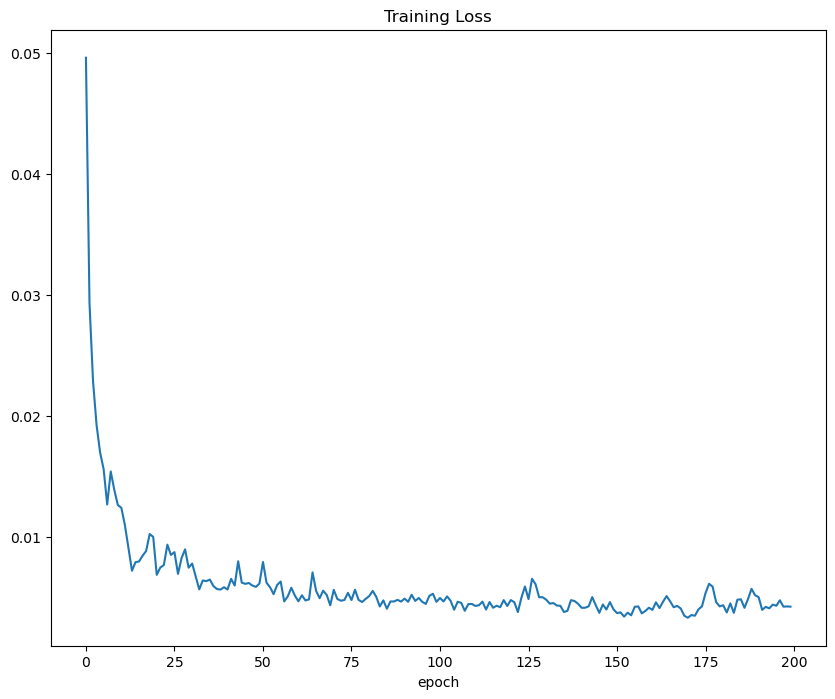

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [48]:
checkpoint = torch.load ('./models/reg4-1.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
loss_ = checkpoint['loss']
ep = checkpoint['epoch']
ls = loss_[-1]

print(f"Best model found at epoch {ep} with lowest loss = {ls}")

Best model found at epoch 170 with lowest loss = 0.0033309698046650738


#### 7. 모델 평가

In [ ]:
# RMSE (Root Mean Squared Error) 
# 예측 성능을 평가할 때 사용
def rmse(dataloader):
  with torch.no_grad(): # requires_grad: 비활성화 => 역전파를 비활성화하여 평가할 때는 모델을 업데이트하지 않아 불필요한 계산을 막는다. 
      square_sum = 0
      num_instances = 0
      model.eval() # 모델을 평가 모드로 바꿈 (아래 추가 설명)

      for data in dataloader:
          inputs, targets = data
          outputs = model(inputs)
          square_sum += torch.sum((outputs - targets)**2).item()
          num_instances += len(targets)

  model.train()

  return np.sqrt(square_sum/num_instances)  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 정규화 기술을 배제하여 온전한 모델로 평가를 해야한다. 따라서 .eval()을 사용한다.
# 즉, 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들이 적용 된 모델은 평가 시에는 비활성화 해야하며 학습 시 .train()을 사용한다.

In [ ]:
train_rmse = rmse(train_loader) # 학습 데이터의 RMSE
test_rmse = rmse(test_loader) # 시험 데이터의 RMSE

print("Train RMSE: %.5f" %train_rmse)
print("Test RMSE: %.5f" %test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요하다.
# 예를 들어 20번의 평가 결과의 평균과 표준편차로 우위 비교를 하거나 신뢰구간을 이용합니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.

Train RMSE: 0.05409
Test RMSE: 0.13408


> Train RMSE가 낮고, Test RMSE가 약간 높은 건 정상적일 수 있다.
>
> 다만 두 값의 차이가 크고, 절대값이 클 경우엔 과적합이나 데이터 문제를 의심해봐야 한다.